In [102]:
import geopandas
import contextily as ctx
import requests
import json
from datetime import datetime
import pandas as pd
import random

import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)

import matplotlib as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline
plt.style.use('ggplot')

# Gather Datasets

### CTA Bus

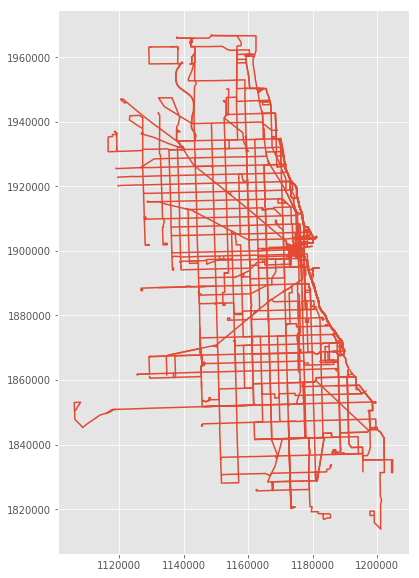

In [2]:
# Get route map
bus_routes = geopandas.read_file("/Users/lauralevy/Downloads/CTA_BusRoutes/CTA_BusRoutes.shp")
bus_routes = bus_routes.to_crs(epsg=3857)
bus_routes.plot(figsize=(10,10))

In [7]:
# Get ridership data
averages = {}

for route in bus_routes.ROUTE:
    url = f'https://data.cityofchicago.org/resource/dv3z-wsyd.json?route={route}'
    temp = pd.read_json(url)
    averages[route]=temp.rides.mean()

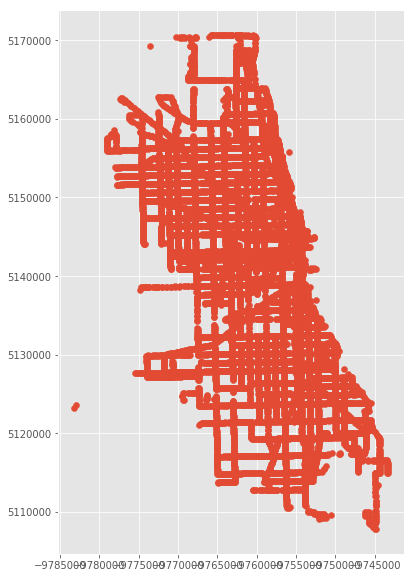

In [8]:
# Get stop locations
bus_stops = geopandas.read_file("/Users/lauralevy/Downloads/CTA_BusStops/CTA_BusStops.shp")
bus_stops = bus_stops.to_crs(epsg=3857)
bus_stops.plot(figsize=(10,10))

### CTA L

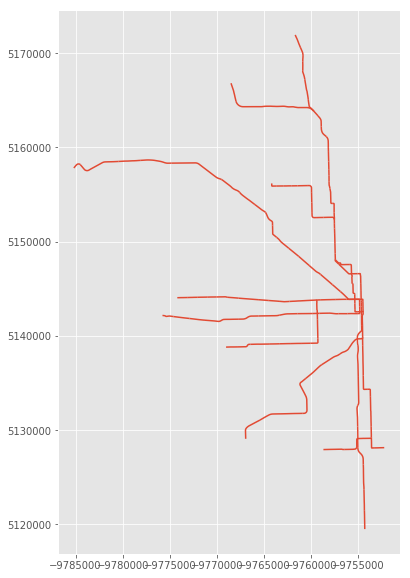

In [9]:
# Get rail line map
rail_lines = geopandas.read_file("/Users/lauralevy/Downloads/CTA_RailLines/CTA_RailLines.shp")
rail_lines = rail_lines.to_crs(epsg=3857)
rail_lines.plot(figsize=(10,10))

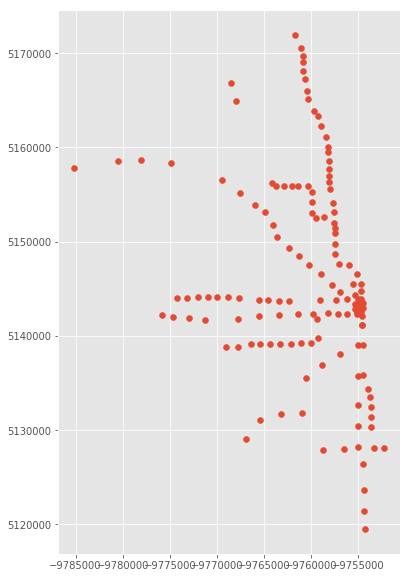

In [69]:
# Get station locations
rail_stations = geopandas.read_file("/Users/lauralevy/Downloads/CTA_RailStations/CTA_RailStations.shp")
rail_stations = rail_stations.to_crs(epsg=3857)
rail_stations.plot(figsize=(10,10))

In [70]:
rail_stations.head()

,OBJECTID,STATION_ID,LONGNAME,LINES,ADDRESS,ADA,PKNRD,POINT_X,POINT_Y,GTFS,geometry
0,2,1120,35-Bronzeville-IIT,Green Line,16 E. 35th Street,1,0,1.177051e+06,1.882048e+06,41120,POINT (-9754468.506051848 5135798.880605994)
1,4,760,Granville,Red Line,1119 W. Granville Avenue,1,0,1.167506e+06,1.941003e+06,40760,POINT (-9758177.761097327 5160030.428180639)
2,6,1210,Wellington,"Brown, Purple (Express)",945 W. Wellington Avenue,1,0,1.169286e+06,1.920014e+06,41210,POINT (-9757516.987586314 5151402.248952111)
3,8,140,Dempster-Skokie,Yellow Line,5001 W. Dempster Street,1,1,1.142190e+06,1.957320e+06,40140,POINT (-9768498.897573812 5166815.85577427)
4,11,370,Washington/Dearborn,Blue Line,19 N. Dearborn,0,0,1.175927e+06,1.900801e+06,40370,POINT (-9754864.645939562 5143494.076814955)


In [78]:
# Get ridership data
averages = {}

for station in rail_stations.STATION_ID[:10]:
    url = f'https://data.cityofchicago.org/resource/mh5w-x5kh.json?station_id={station}'
    print(station)
    try:
        temp = pd.read_json(url)
        averages[station]=temp.rides.mean()
        print('success' + ' url: ' + url)
    except:
        print('fail' + ' url: ' + url)

1120
fail url: https://data.cityofchicago.org/resource/mh5w-x5kh.json?station_id=1120
760
fail url: https://data.cityofchicago.org/resource/mh5w-x5kh.json?station_id=760
1210
fail url: https://data.cityofchicago.org/resource/mh5w-x5kh.json?station_id=1210
140
fail url: https://data.cityofchicago.org/resource/mh5w-x5kh.json?station_id=140
370
fail url: https://data.cityofchicago.org/resource/mh5w-x5kh.json?station_id=370
1480
fail url: https://data.cityofchicago.org/resource/mh5w-x5kh.json?station_id=1480
1440
fail url: https://data.cityofchicago.org/resource/mh5w-x5kh.json?station_id=1440
90
fail url: https://data.cityofchicago.org/resource/mh5w-x5kh.json?station_id=90
160
fail url: https://data.cityofchicago.org/resource/mh5w-x5kh.json?station_id=160
1490
fail url: https://data.cityofchicago.org/resource/mh5w-x5kh.json?station_id=1490


In [87]:
#get all stations
rail_ridership = pd.read_csv("/Users/lauralevy/Downloads/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv")
station_averages = rail_ridership.groupby('station_id').mean()

### Get Street Data From Open Street Maps

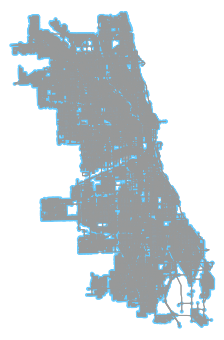

In [101]:
G = ox.graph_from_place('Chicago, Illinois, USA', network_type='drive')
fig, ax = ox.plot_graph(G)

Let's look at a routing example by chosing two random CTA stations

In [105]:
start_index = random.randint(0,rail_stations.shape[0])
end_index = random.randint(0,rail_stations.shape[0])

In [110]:
start_x = rail_stations['POINT_X'][start_index]
start_y= rail_stations['POINT_Y'][start_index]

end_x = rail_stations['POINT_X'][end_index]
end_y= rail_stations['POINT_Y'][end_index]

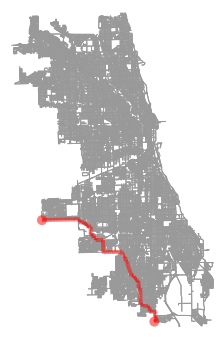

In [111]:
# get the nearest network node to each point
start_node = ox.get_nearest_node(G, (start_x, start_y))
end_node = ox.get_nearest_node(G, (end_x, end_y))

# find the route between these nodes then plot it
route = nx.shortest_path(G, start_node, end_node, weight='length')
fig, ax = ox.plot_graph_route(G, route, node_size=0)